In [77]:

from langchain.prompts import ChatPromptTemplate 
from langgraph.graph import StateGraph, END, START
from langchain_core.tools import Tool
from langgraph.prebuilt import ToolNode, tools_condition

from typing import Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


In [78]:
import sqlite3
import os
import json

openai_api_key = os.environ.get('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-4o", temperature=0.7, openai_api_key=openai_api_key)

conn = sqlite3.connect('mydatabase.db', check_same_thread=False)  
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Users (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        email TEXT NOT NULL,
        phone TEXT NOT NULL
    );
    ''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Bookings(
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_id INTEGER,
        flight_id INTEGER,
        FOREIGN KEY (user_id) REFERENCES Users(id),
        FOREIGN KEY (flight_id) REFERENCES Flights(id)
    );
    ''')

conn.commit()


In [80]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Flights(
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        airline TEXT NOT NULL,
        time INT NOT NULL,
        price INT NOT NULL,
        dept TEXT NOT NULL,
        dest TEXT NOT NULL
    );
    ''')

data = [
    ("vistara", 1230, 6000, "mumbai", "delhi"),
    ("indigo", 740, 5699, "banglore", "delhi"),
    ("vistara", 1120, 3400, "delhi", "banglore"),
    ("vistara", 810, 4277, "delhi", "mumbai"),
    ("indigo", 1200, 7800, "mumbai", "banglore"),
    ("vistara", 1530, 5355, "mumbai", "delhi"),
    ("akasa", 2300, 3999, "banglore", "delhi"),
    ("akasa", 2245, 4890, "mumbai", "delhi")
]

cursor.executemany('''
    INSERT INTO Flights (airline, time, price, dept, dest) VALUES (?, ?, ?, ?, ?)
    ''',
    (data))

conn.commit()

In [81]:
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

engine = create_engine(
    "sqlite://",
    creator=lambda: conn,
    poolclass=StaticPool,
    connect_args={"check_same_thread": False}
)

db = SQLDatabase(engine)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

toolkit.get_tools()

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10f30b590>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10f30b590>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10f30b590>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [82]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

search_api = DuckDuckGoSearchAPIWrapper()

@tool
def search(query: str):
    """Call to surf the web."""
    response = search_api.run(query)
    return response

search_tool = Tool(
    name="search",
    func=search,
    description="""can give current and latest information from the web. 
    But dont use this if user asks for flight details and information because we need to use our own flight system.
    """
)

In [83]:

@tool
def register(query: str):
    """
        helps registering users with name, email and phone in the flight booking system
        use this tool whenever user wants to register and inputs credentials of name, email and phone
    """

    # prompt = ChatPromptTemplate.from_template(
    #     """  
    #         user input: {query}
    #         extract name, email and phone in string format with comma seperated like this:
    #         <name>, <email>, <phone>
    #     """
    # )
    # response = llm.invoke(prompt.format_messages(query=query))
    
    # fields = response.content.split(",")
    # name = fields[0].strip() 
    # email = fields[1].strip() 
    # phone = fields[2].strip() 

    try:
        data = json.loads(query)
        name = data.get('name')
        email = data.get('email')
        phone = data.get('phone')
    except json.JSONDecodeError:
        return {"message": data}

    if email:
        cursor.execute('''
            SELECT * FROM User
            WHERE email = ?
            ''', 
            (email,))
        rows = cursor.fetchall()
        if rows:
            return "user already registered"

    if name and email and phone:
        cursor.execute('''
            INSERT INTO User (name, email, phone) 
            VALUES (?, ?, ?)
            ''', 
            (name, email, phone))
        conn.commit()
        return "registration successfully completed"
    
    return "please provide all details"


register_tool = Tool(
    name="register",
    func=register,
    description="helps in registering the user with name, email and phone"
)


In [84]:

@tool
def booking(query: str):
    """ 
        use this tool whenever user wants to book a flight 
    """
    
    # prompt = ChatPromptTemplate.from_template(
    #     """  
    #         user input: {query}
    #         extract email, airline and time in string format with comma seperated like this:
    #         <email>, <airline>, <time>
    #     """
    # )
    # response = llm.invoke(prompt.format_messages(query=query))
    
    # fields = response.content.split(",")
    # email = fields[0].strip() 
    # airline = fields[1].strip() 
    # time = fields[2].strip() 

    try:
        data = json.loads(query)
        email = data.get('email')
        airline = data.get('airline')
        time = data.get('time')
    except :
        return "invalid json. error in formatting"

    if email:
        cursor.execute('''
            SELECT * FROM User
            WHERE email = ?
            ''', 
            (email,))
        rows = cursor.fetchall()
        if not rows:
            return "kindly register before booking flight"

    if email and airline and time:
        cursor.execute('''
            INSERT INTO Flights (email, airline, time) 
            VALUES (?, ?, ?)
            ''', 
            (email, airline, time))
        conn.commit()
        return "booking done successfully"
    
    return "please provide all details"

    
booking_tool = Tool(
    name="booking",
    func=booking,
    description="helps in booking flights with email, airline and time"
)

In [85]:

tools = [register_tool, booking_tool, search_tool] + toolkit.get_tools()
tool_node = ToolNode(tools)
llm2 = llm.bind_tools(tools)


def agent(state: MessagesState):
    messages = state['messages']
    response = llm2.invoke(messages)
    return {"messages": [response]}


In [100]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition
)
workflow.add_edge("tools", 'agent')

checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

In [ ]:
def user_func():
    flag = True
    user_input = input("User: ")
    state = {"messages": [HumanMessage(content=user_input)]}
    config = {"configurable": {"thread_id": 1}}
    
    while True:
        state = app.invoke(state, config)
        
        latest_response = state["messages"][-1].content
        print("Agent:", latest_response)

        if len(state["messages"]) >= 5 and flag:
            flag = False
            all_states = [s for s in app.get_state_history(config)]
            for st in app.get_state_history(config):
                print("Num Messages: ", len(st.values["messages"]), "Next: ", st.next, "  ", st.config)
                print("-" * 80)
            to_fork = all_states[1]
            print(to_fork.config)
            print(to_fork.values["messages"])

            print("\n State :", state, "\n")

            fork_config = app.update_state(to_fork.config,{"messages": [HumanMessage(content='Multiply 5 and 3', id=to_fork.values["messages"][-1].id)]},) 
            print(fork_config)

            all_states = [s for s in app.get_state_history(config)]
            print(all_states[0].values["messages"])

            print("\n", app.get_state(config))

            state["messages"] = app.get_state(config).values["messages"]
            state = app.invoke(state, fork_config)
            latest_response = state["messages"][-1].content
            print("Agent:", latest_response)

            print("\n", state)

            all_states = [s for s in app.get_state_history(config)]
            print(all_states[0].values["messages"])
        
        user_input = input("You: ")
        
        if user_input.lower() in ["stop", "exit", "quit", "q"]:
            break
        
        state["messages"].append(HumanMessage(content=user_input))

user_func()

Agent: The expression "1-1" equals 0. If you meant something else by "1-1," please provide more context!
Agent: The expression "2-2" equals 0. If you have any other questions or need further assistance, feel free to ask!
Agent: The expression "3-3" equals 0. Let me know if there's anything else you'd like to know!
Num Messages:  6 Next:  ()    {'configurable': {'thread_id': 1, 'checkpoint_ns': '', 'checkpoint_id': '1efb13a7-ad5f-6988-8007-8277ca0771c1'}}
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('agent',)    {'configurable': {'thread_id': 1, 'checkpoint_ns': '', 'checkpoint_id': '1efb13a7-a55a-6260-8006-671c433c4499'}}
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)    {'configurable': {'thread_id': 1, 'checkpoint_ns': '', 'checkpoint_id': '1efb13a7-a557-670e-8005-5a99d0095b0b'}}
-------------------------------------------------------------------------

In [58]:

cursor.execute('SELECT * FROM Users')
rows = cursor.fetchall()

for row in rows:
    print(row)

# cursor.execute('DELETE FROM User') 
conn.commit()
print(' ')

cursor.execute('SELECT * FROM Bookings')
rows = cursor.fetchall()

for row in rows:
    print(row)

# cursor.execute('DELETE FROM Flights')
conn.commit()

# conn.close()

(1, 'abc', 'abc@g.com', '123')
 
(1, 1, 6)


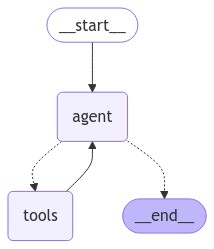

In [45]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
[HumanMessage(content='1-1', additional_kwargs={}, response_metadata={}, id='24d549fc-5969-4f48-8f2b-f48200ceb399'), AIMessage(content='The expression "1-1" equals 0. If you meant something else by "1-1," please provide more context!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 436, 'total_tokens': 464, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-bc20e672-c2fa-4f5d-8fbd-f7fc931fa23a-0', usage_metadata={'input_tokens': 436, 'output_tokens': 28, 'total_tokens': 464, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='2-2', additional_kwargs={}, response_metadata={}, id='e41d130f-6976-4912-84e3-380fa226221c'), AIMessage(content='The expression "2-2" equals 0. If you have any other questions or need further assistance, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 474, 'total_tokens': 502, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae6bcc8a-969d-435c-8701-f9ee1ec581f2-0', usage_metadata={'input_tokens': 474, 'output_tokens': 28, 'total_tokens': 502, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ab2ae7d0-f442-4a7d-8cb7-b76cdc745428'), AIMessage(content='The product of 5 and 3 is 15.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 515, 'total_tokens': 528, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-81061067-2e6b-484b-a832-ab7232bc42d8-0', usage_metadata={'input_tokens': 515, 'output_tokens': 13, 'total_tokens': 528, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]